# pandas-ml-qunat - The Pandas Machine Leraning and Quant Finance Library

This is the root repository of the follwoing 3 core components:

* pandas-ml-common - a more general utilities and monkey patched pandas objects provider
* pandas-ml-quant - provides technical analysis inidcators, plots, loss functions, etc.
* pandas-ml-utils - apply statistical or ml models directly to data frames

## Demonstration of all 3 libraries used together
### First import needed objects

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from pandas_ml_utils.ml.data.extraction import extract_with_post_processor
from pandas_ml_utils.ml.summary import ClassificationSummary
from pandas_ml_utils import FeaturesAndLabels, Model, SkModel
from pandas_ml_quant import pd, np

automatically imported pandas_ml_utils 0.1.0


### Next fetch some stock data and plot it

Note that:
1. all indicators and charting functionalities are behind the **q**and property attached to all pandas objects
1. the **m**achine**l**earning proptery provides access to (raw) data as it is useful/needed by statistical and ml models
1. all model relevant functionalities are behind the **model** property


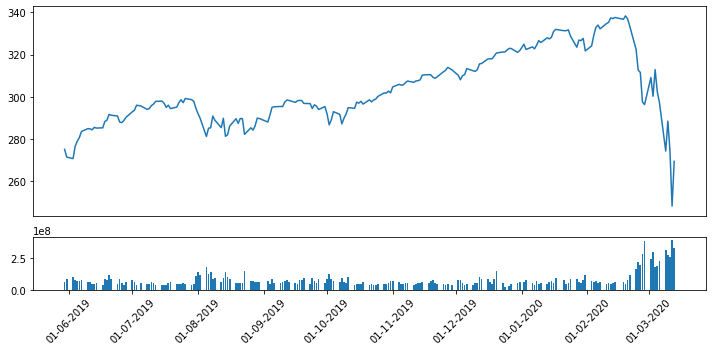

In [2]:
df = pd.fetch_yahoo("SPY")

# NOTE the access to the q_uant property
df[-200:].q.ta_plot(figsize=(10, 5))()

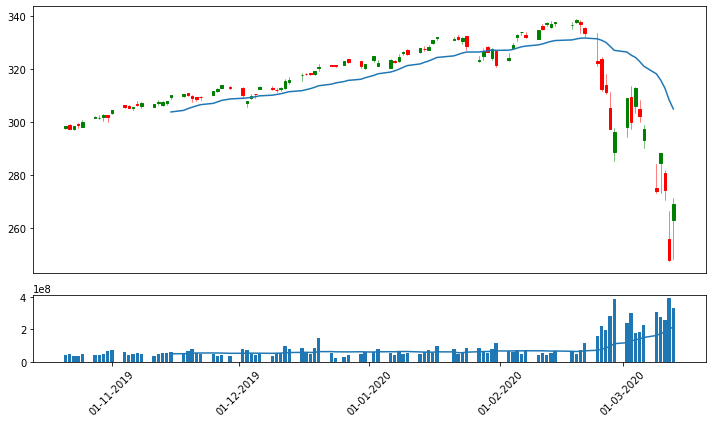

In [3]:
plt = df[-100:].q.ta_plot(figsize=(10, 6))
plt.candlestick()
plt.line(df[-100:]["Close"].q.ta_sma(period=20))
plt.bar("Volume")
plt.line(df[-100:]["Volume"].q.ta_sma(period=20), panel=1)

### Next think of a predictive model
Lets say we want to predict whether two moving averages are corssing within the next 5 days in the future or not.

In [4]:
# NOTE all technical analysis starts with the "ta_" prefix
df["Close"].q.ta_sma(period=60)\
           .q.ta_cross(df["Close"].q.ta_sma(period=20))\
           .q.ta_rnn([1,2,3,4,5])\
           .abs()\
           .sum(axis=1)\
           .shift(-5)\
           .tail(10)

Date
2020-03-02    1.0
2020-03-03    1.0
2020-03-04    1.0
2020-03-05    1.0
2020-03-06    0.0
2020-03-09    NaN
2020-03-10    NaN
2020-03-11    NaN
2020-03-12    NaN
2020-03-13    NaN
dtype: float64

And we want to predict this binary event based on a set of indicators like the RSI (Relative Strength Index) and such.

So we can build up a features and labels definition like so:

In [5]:
fnl = FeaturesAndLabels(
    features=[
        lambda df: df["Close"].q.ta_macd(),
        lambda df: df["Close"].q.ta_apo(),
        lambda df: df["Close"].q.ta_rsi(),
        lambda df: df["Close"].q.ta_roc(),
        lambda df: df["Close"].q.ta_trix(),
        lambda df: df["Close"].q.ta_ppo(),
        lambda df: df["Close"].pct_change().q.ta_zscore() / 4.,
        lambda df: df["Close"].q.ta_week_day(),
        lambda df: df["Close"].q.ta_week(),
        lambda df: df["Close"].q.ta_up_down_volatility_ratio(),
        lambda df: df.q.ta_adx(), 
        lambda df: df.q.ta_atr(),
        lambda df: df.q.ta_tr(),
        lambda df: df.q.ta_williams_R(),
        lambda df: df.q.ta_ultimate_osc(),
        lambda df: df.q.ta_bop(),
        lambda df: df.q.ta_cci(),
    ],
    labels=[
        lambda df: df["Close"].q.ta_sma(period=60)\
                              .q.ta_cross(df["Close"].q.ta_sma(period=20))\
                              .q.ta_rnn([1,2,3,4,5])\
                              .abs()\
                              .sum(axis=1)\
                              .shift(-5)\
                              .astype(bool)
    ]
)

# NOTE the df.ml property provides access to (raw) data as it is useful/needed by statistical models
features, labels, targets, weights = df.ml.extract(fnl)
features.describe()

  res = df.rolling(period).apply(lambda c: zscore(c, ddof=ddof)[-1])

  md = tp.rolling(period).apply(lambda x: _np.abs(x - x.mean()).sum() / period)



,"macd_12,26,9","signal_12,26,9","histogram_12,26,9","Close_apo_12,26,0",Close_rsi_14,Close_roc_10,Close_trix_30,"Close_ppo_12,26,1",Close_z_20,dow,...,-DM,+DI,-DI,ADX,atr_14,true_range,williams_R_14,"ultimate_osc_7,14,28",bop,cci_14
count,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,...,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000
mean,0.002448,0.002468,-0.000021,1.002555,0.549323,0.004016,0.036944,0.002448,-0.007575,0.336841,...,0.003469,0.002994,0.002841,0.231586,1.489611,1.513250,0.377704,0.546815,0.035688,0.240053
std,0.010902,0.010202,0.003346,0.015241,0.113827,0.031406,0.104855,0.010902,0.246378,0.233422,...,0.002762,0.002434,0.002135,0.083930,0.943247,1.396082,0.301386,0.101926,0.535341,1.052522
min,-0.074439,-0.067679,-0.026184,0.891753,0.167987,-0.267695,-0.558651,-0.074439,-0.972346,0.000000,...,0.000385,0.000195,0.000205,0.076091,0.147346,0.040000,0.000000,0.213749,-1.000000,-3.522097
25%,-0.002280,-0.001862,-0.001826,0.995338,0.468740,-0.010814,-0.004692,-0.002280,-0.160098,0.166667,...,0.001728,0.001473,0.001469,0.168674,0.906715,0.750000,0.104944,0.474888,-0.418393,-0.567375
50%,0.004360,0.004190,-0.000021,1.004710,0.557265,0.006616,0.053190,0.004360,-0.008159,0.333333,...,0.002673,0.002294,0.002270,0.217155,1.332596,1.200000,0.306452,0.550386,0.053333,0.463479
75%,0.009253,0.008945,0.001736,1.011822,0.634070,0.021490,0.100340,0.009253,0.153060,0.500000,...,0.004237,0.003372,0.003374,0.278931,1.846375,1.860000,0.628261,0.621077,0.500000,1.054975
max,0.030255,0.026989,0.018455,1.059521,0.872283,0.215963,0.248463,0.030255,0.839008,0.666667,...,0.027597,0.015448,0.017921,0.590979,12.352301,26.680000,1.000000,0.846781,1.000000,3.215749


Since we have no idea which features are actually "good" to predict the label, we want to do some feature analysis fist.


  res = df.rolling(period).apply(lambda c: zscore(c, ddof=ddof)[-1])

  md = tp.rolling(period).apply(lambda x: _np.abs(x - x.mean()).sum() / period)



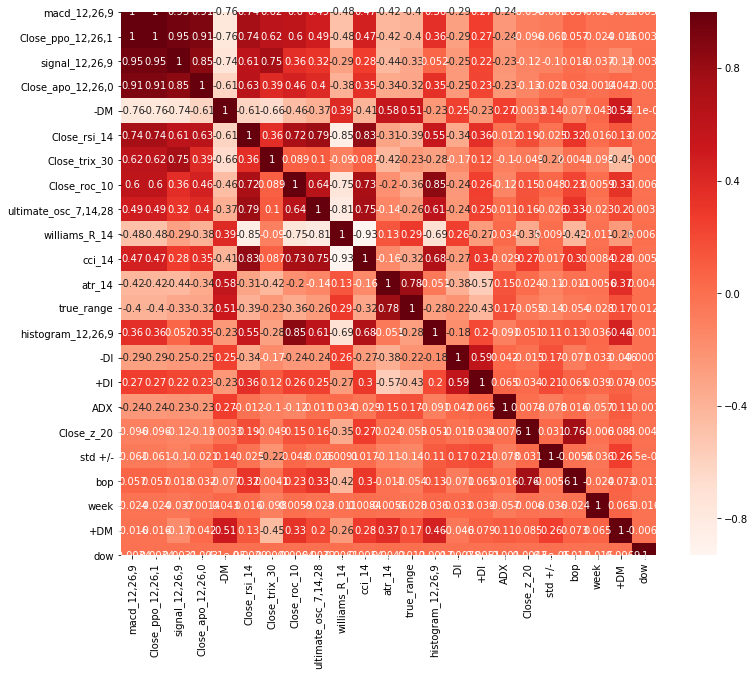

  forest.fit(x, y)



              macd_12,26,9  Close_ppo_12,26,1  signal_12,26,9  \
macd_12,26,9           1.0                1.0        0.951855   

              Close_apo_12,26,0       -DM  Close_rsi_14  Close_trix_30  \
macd_12,26,9           0.905793 -0.760603      0.744878       0.616404   

              Close_roc_10  ultimate_osc_7,14,28  williams_R_14  ...  \
macd_12,26,9      0.601408                0.4904      -0.483504  ...   

              histogram_12,26,9       -DI       +DI       ADX  Close_z_20  \
macd_12,26,9           0.355952 -0.289407  0.267997 -0.239336   -0.095821   

               std +/-       bop      week       +DM       dow  
macd_12,26,9 -0.060928  0.057221 -0.023718 -0.015873 -0.003399  

[1 rows x 23 columns]
label is continuous: False


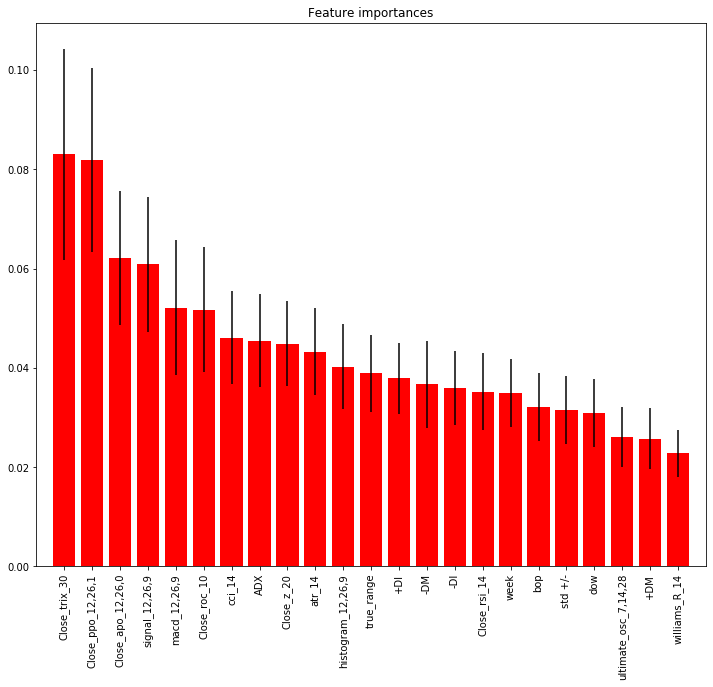

Feature ranking:
['Close_trix_30', 'Close_ppo_12,26,1', 'Close_apo_12,26,0', 'signal_12,26,9', 'macd_12,26,9', 'Close_roc_10', 'cci_14', 'ADX', 'Close_z_20', 'atr_14', 'histogram_12,26,9', 'true_range', '+DI', '-DM', '-DI', 'Close_rsi_14', 'week', 'bop', 'std +/-', 'dow', 'ultimate_osc_7,14,28', '+DM', 'williams_R_14']

TOP 5 features
               Close_trix_30  Close_ppo_12,26,1  Close_apo_12,26,0  \
Close_trix_30            1.0           0.616404           0.393714   

               signal_12,26,9  macd_12,26,9  
Close_trix_30        0.752091      0.616404  

filter feature Close_ppo_12,26,1 with correlation 1.0 > 0.5

filter feature macd_12,26,9 with correlation 1.0 > 0.5

filter feature Close_apo_12,26,0 with correlation 1.0 > 0.5

filter feature signal_12,26,9 with correlation 1.0 > 0.5
Features after correlation filer:
              Close_trix_30
macd_12,26,9       0.616404


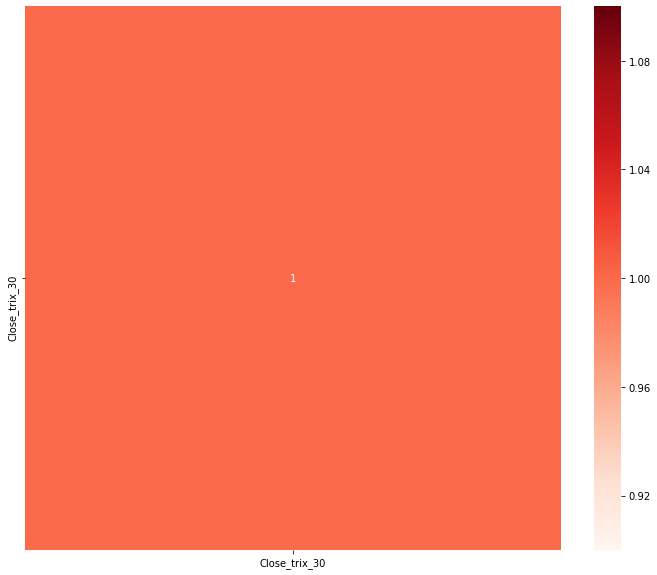

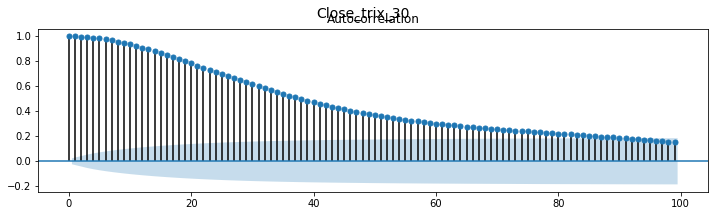

Close_trix_30      1.000000
Close_trix_30_0    1.000000
Close_trix_30_1    0.999270
Close_trix_30_2    0.997099
Close_trix_30_3    0.993521
Close_trix_30_4    0.988586
Close_trix_30_5    0.982350
Close_trix_30_6    0.974880
Close_trix_30_7    0.966243
Close_trix_30_8    0.956515
Name: Close_trix_30, dtype: float64
best lags are
[(1, '-1.00'), (2, '-1.00'), (3, '-1.00'), (4, '-0.99'), (5, '-0.99'), (6, '-0.98'), (7, '-0.97'), (8, '-0.97'), (9, '-0.96'), (10, '-0.95'), (11, '-0.93'), (12, '-0.92'), (13, '-0.91'), (14, '-0.89'), (15, '-0.88'), (16, '-0.86'), (17, '-0.85'), (18, '-0.83'), (19, '-0.82'), (20, '-0.80'), (21, '-0.78'), (22, '-0.77'), (23, '-0.75'), (24, '-0.73'), (25, '-0.71'), (26, '-0.70'), (27, '-0.68'), (28, '-0.66'), (29, '-0.65'), (30, '-0.63'), (31, '-0.61'), (32, '-0.60'), (33, '-0.58'), (34, '-0.57'), (35, '-0.55'), (36, '-0.54'), (37, '-0.52'), (38, '-0.51'), (39, '-0.50'), (40, '-0.48'), (41, '-0.47'), (42, '-0.46'), (43, '-0.45'), (44, '-0.44'), (45, '-0.43'), (46

In [6]:
features, lags = df.model.feature_selection(fnl)

In [7]:
features

['Close_trix_30',
 'Close_ppo_12,26,1',
 'Close_apo_12,26,0',
 'signal_12,26,9',
 'macd_12,26,9']

Looks like 'Close_trix_30', 'Close_ppo_12,26,1', 'Close_apo_12,26,0', 'signal_12,26,9', 'macd_12,26,9' are the top 5 features to predict the label 
(which is wheter the 60 sma is crossing the20 sma withing the next 5 days or not)

So we can now build up a model from the learnings we have made.

In [8]:
fit = df.model.fit(
    SkModel(
        MLPClassifier(activation='tanh', hidden_layer_sizes=(60, 50), random_state=42),
        FeaturesAndLabels(
            features=extract_with_post_processor(
                [
                    lambda df: df["Close"].q.ta_trix(),
                    lambda df: df["Close"].q.ta_ppo(),
                    lambda df: df["Close"].q.ta_apo(),
                    lambda df: df["Close"].q.ta_macd(),        
                    lambda df: df.q.ta_adx(), 
                ],
                lambda df: df.q.ta_rnn(lags)
            ),
            labels=[
                lambda df: df["Close"].q.ta_sma(period=60)\
                      .q.ta_cross(df["Close"].q.ta_sma(period=20))\
                      .q.ta_rnn([1,2,3,4,5])\
                      .abs()\
                      .sum(axis=1)\
                      .shift(-5)\
                      .astype(bool)

            ],
            min_required_samples=max(lags)
        ),
        summary_provider=ClassificationSummary
    )
)

fit

It very much looks like the model has a good accuracy but when we look at the confusion matrix, then we can see that the true event (averages are crosing each other) is never predicted.
So this model just says no and most of the time this is correct. It is as if a model predicts "today is not Christmas" which would also have an accuracy of 99.7. However it fails miserably to predict Christmas.

Thi is why we need to fix this under representation of classes by either using sample weights or by boosting the samples in a cross validation algorithm.

Lets try to use a k-fold cross validation algorithm with sample boosing

In [24]:
from pandas_ml_utils.ml.data.sampeling import KFoldBoostRareEvents
from pandas_ml_utils import KerasModel

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, ActivityRegularization
from keras.callbacks import EarlyStopping
from keras import backend as K 

# first clear tensorflow session
K.clear_session()

def provider():
    # create model
    model = Sequential()
    model.add(Reshape((101 * 11, ), input_shape=(101, 11)))
    # model.add(ActivityRegularization(l1=0.002))
    model.add(Dense(60, activation='tanh'))
    model.add(Dense(50, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='mse',
                  optimizer=Adam(lr=0.0001), 
                  metrics=['accuracy'],
                 )
    
    return model
    
fit = df.model.fit(
    KerasModel(
        provider,
        FeaturesAndLabels(
            features=extract_with_post_processor(
                [
                    lambda df: df["Close"].q.ta_trix(),
                    lambda df: df["Close"].q.ta_ppo(),
                    lambda df: df["Close"].q.ta_apo(),
                    lambda df: df["Close"].q.ta_macd(),        
                    lambda df: df.q.ta_adx(), 
                ],
                lambda df: df.q.ta_rnn(lags)
            ),
            labels=[
                lambda df: df["Close"].q.ta_sma(period=20)\
                      .q.ta_cross(df["Close"].q.ta_sma(period=10))\
                      .q.ta_rnn([1,2,3,4,5])\
                      .abs()\
                      .sum(axis=1)\
                      .shift(-5)\
                      .astype(bool)

            ],
            sample_weights=[
                lambda df: df["Close"].q.ta_sma(period=20)\
                      .q.ta_cross(df["Close"].q.ta_sma(period=10))\
                      .q.ta_rnn([1,2,3,4,5])\
                      .abs()\
                      .sum(axis=1)\
                      .shift(-5) + (20)
            ],
            min_required_samples=max(lags)
        ),
        summary_provider=ClassificationSummary,
        # keras fit parameters
        verbose=0,
        batch_size=128,
        callbacks=[lambda: EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)], 
    ),
    test_size=0.4, 
    test_validate_split_seed=42, 
    cross_validation=(1, KFoldBoostRareEvents(n_splits=3).split),
    
)

fit

using sample weights (3617,)
pass args to fit: {'verbose': 0, 'batch_size': 128}
using sample weights (3617,)
pass args to fit: {'verbose': 0, 'batch_size': 128}
using sample weights (3617,)
pass args to fit: {'verbose': 0, 'batch_size': 128}
